#### Useful imports and extensions

In [91]:
import jsonlines
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark import SparkContext
import numpy as np
import json
import plotly.express as px
from plotly import graph_objects as go
from tqdm import tqdm
import statsmodels.formula.api as smf

from classify_google_utils import classify_all



%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading dataset and extracting climate change related videos

We want to study youtube videos related to climate change : the first step is to filter our broad dataset of all videos.
For this, we generated a list of keywords related to climate change :

In [2]:
with open('keywords.json') as f:
    keywords = json.load(f)['keywords']

for k in keywords:
    print(k)

climate change
global warming
greenhouse gases
rising sea levels
extreme weather
temperature increase
climate action
carbon emissions
renewable energy
sustainable living
climate science
climate crisis
climate adaptation
natural disaster
extreme heat
melting ice cap
sea level rise
biodiversity loss
deforestation
ocean acidification
climate policy
environmental policy
disaster recovery
climate refugees
carbon footprint
sustainable development
green technology
renewable resource
eco-friendly
ecosystem disruption
impact on climate
paris agreement
climate awareness
environmental justice
clean energy
zero carbon
green infrastructure
ozone layer
pollution
water scarcity
climate education


We create functions to check if a video contains climate change related keywords in its title, description or tags

In [ ]:
def about_climate(tags):
    tags_set = set(tags)
    return any(tag.strip().lower() in keywords for tag in tags_set)

def climate_text(text):
    lowercase_text = text.lower()
    return any(keyword in lowercase_text for keyword in keywords)

def climate_related(video):
    return (climate_text(video['title']) or about_climate(video['tags']) or climate_text(video['description']))

Since the original video metadata dataset is huge (97 GB), we read and filter the dataset using pyskark in order to get a reduced dataset with only the relevant videos.

### Load the dataset

In [ ]:
path_to_disk = '/Volumes/Maxtor'
file_path = '/yt_metadata_en.jsonl'

sc = SparkContext()
raw_data = sc.textFile(path_to_disk + file_path)
video_dataset = raw_data.map(lambda x: json.loads(x))

### Filter the dataset

In [ ]:
climate_videos = video_dataset.filter(climate_related)
climate_videos_collected = climate_videos.collect()

In [ ]:
climate_videos_path = "data/coarse_filter_climate_videos.jsonl"
with jsonlines.open(climate_videos_path, "w") as jsonl_file:
   jsonl_file.write_all(climate_videos_collected)

#### Sample dataset

We create 2 random sample dataset (1% ands 0.1%) which may be useful later in our analysis for statisitical comparison with the cliamte related videos dataset.

In [ ]:
seed = 42

random_sample_1percent = video_dataset.sample(False, 0.01, seed=seed)
random_sample_1percent_collected = random_sample_1percent.collect()
sample_1percent_path = "data/sample_1percent.jsonl"
with jsonlines.open(sample_1percent_path, "w") as jsonl_file:
    jsonl_file.write_all(random_sample_1percent_collected)


random_sample_01percent = video_dataset.sample(False, 0.001, seed=seed)
random_sample_01percent_collected = random_sample_01percent.collect()
sample_01percent_path = "data/sample_01percent.jsonl"
with jsonlines.open(sample_01percent_path, "w") as jsonl_file:
    jsonl_file.write_all(random_sample_01percent_collected)


In [ ]:
sc.stop()

### Extracting useful features from the whole dataset

We keep working on the whole dataset in order to extract useful features which may be useful later for comparison purpose. We use the .feather helper for this. 

In [2]:
feather_path = "data/yt_metadata_helper.feather"
video_dataset_feather = pd.read_feather(feather_path)

In [12]:
video_count_by_date_cat = video_dataset_feather.groupby(['upload_date', 'categories']).size().reset_index(name='count')
video_count_by_date_cat['upload_date'] = video_count_by_date_cat['upload_date'].dt.strftime('%Y-%m-%d')
video_count_by_date = video_count_by_date_cat[['upload_date', 'count']].groupby(['upload_date']).sum().reset_index()
video_count_by_cat = video_count_by_date_cat[['categories', 'count']].groupby(['categories']).sum().reset_index()
nb_videos = video_dataset_feather.shape[0]
print(f"Number of videos: {nb_videos}")

Number of videos: 72924794


In [9]:
video_count_by_date_cat.to_json("data/nb_videos_by_date_cat.jsonl", orient="records", lines=True)
video_count_by_date.to_json("data/nb_videos_by_date.jsonl", orient="records", lines=True)
video_count_by_cat.to_json("data/nb_videos_by_cat.jsonl", orient="records", lines=True)

### Filtering refinment

In [4]:
coarse_filter_climate_videos_path = "data/climate_videos.jsonl" 
coarse_filter_climate_videos = pd.read_json(coarse_filter_climate_videos_path, lines=True)
nb_coarse_climate_videos = coarse_filter_climate_videos.shape[0]
print(f"Number of climate related videos {nb_coarse_climate_videos}")

Number of climate related videos 145008


Even though we filtered out a lot of videos, we still observed several non climate related videos. Hence we have to perform a beter filtering. Having much less data allows us to use a much more costly but more accurate filtering method: using an NLP classifier. We use the google content classifier.

### Classifying videos using google content classifier

In [ ]:
google_credentials_path = "silent-circlet-407818-8bcb92199b3e.json"
classified_coarse_filter_climate_videos_df = classify_all(video_dataframe=coarse_filter_climate_videos, credentials_path=google_credentials_path)

In [ ]:
classified_path = "data/climate_videos_sample_classified.jsonl"
classified_coarse_filter_climate_videos_df.to_json(classified_path, orient="records", lines=True)

Now that we could give more categories to each videos, we will use these to filter out more videos

### Further filtering using the google classification
We do a second filtering to keep only videos that contain at least one climate-related category according to Google content classifier.

First we define the list of climate-related categories, and then we filter the dataframe with it.

In [ ]:
most_common_categories = classified_coarse_filter_climate_videos_df['classification_categories'].explode().unique()
# remove nan and non category values
most_common_categories = [category for category in most_common_categories 
                          if isinstance(category, str) and category.startswith('/')]

In [ ]:
climate_related_categories = []

# Filter categories with the keywords
for cat in most_common_categories:
    if any(keyword in cat for keyword in keywords):
        climate_related_categories.append(cat)

# Manualy remove non relevant ones
climate_related_categories.remove('/News/Business News/Economy News')
climate_related_categories.remove('/People & Society/Social Sciences/Economics')
climate_related_categories.remove('/Health/Health Conditions/Allergies/Environmental Allergies')

In [ ]:
climate_related_categories

['/People & Society/Social Issues & Advocacy/Green Living & Environmental Issues',
 '/Science/Ecology & Environment/Other',
 '/Science/Ecology & Environment/Climate Change & Global Warming',
 '/Business & Industrial/Energy & Utilities/Renewable & Alternative Energy',
 '/Shopping/Green & Eco-Friendly Shopping',
 '/Travel & Transportation/Specialty Travel/Ecotourism']

In [ ]:
df = classified_coarse_filter_climate_videos_df[classified_coarse_filter_climate_videos_df['classification_categories']
                                        .apply(lambda x: any(category in x.keys() for category in climate_related_categories))]

In [ ]:
df.to_json('climate_videos_v3.jsonl', orient='records', lines=True)

We finally export the double-filtered dataframe in a jsonl file:

In [3]:
final_filter_climate_videos_path = "data/climate_videos_v3.jsonl"
climate_videos_df = pd.read_json(final_filter_climate_videos_path, lines=True)
nb_climate_videos = climate_videos_df.shape[0]

The filtering steps result in:

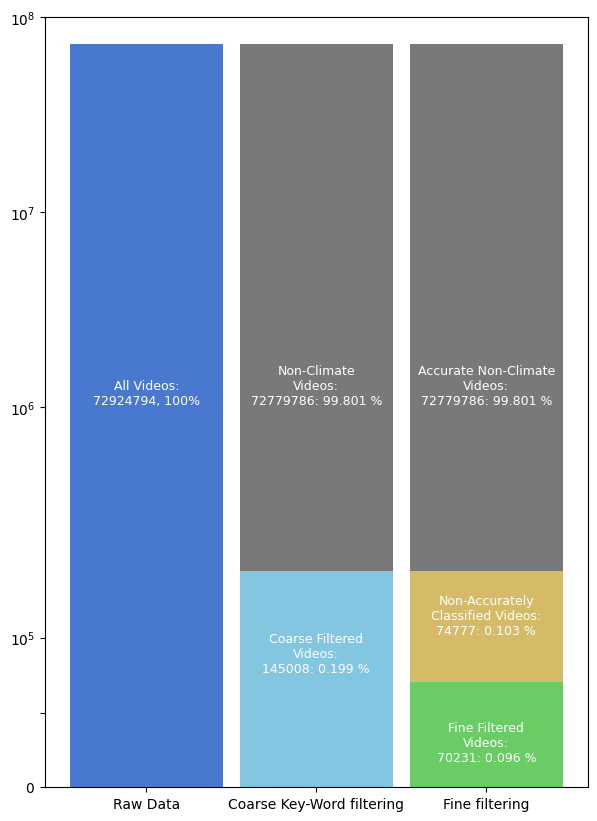

In [153]:
STEPS = ('Raw Data', 'Coarse Key-Word filtering', 'Fine filtering')
COLORS = sns.color_palette("muted")
WIDTH = 0.9
FIG_SIZE = (7, 10)
FONT_SIZE = 9

nb_videos_plotting = nb_videos
non_climate_videos = nb_videos_plotting - nb_coarse_climate_videos
non_accurately_classified = nb_coarse_climate_videos - nb_climate_videos
accurate_non_climate_videos = nb_videos_plotting - nb_climate_videos - non_accurately_classified

weight_counts = {
    "Below": ([nb_videos_plotting, nb_coarse_climate_videos, nb_climate_videos], [COLORS[0], COLORS[9], COLORS[2]]),
    "Middle": ([0, non_climate_videos, non_accurately_classified], [COLORS[0], COLORS[7], COLORS[8]]),
    "Above": ([0, 0, accurate_non_climate_videos], [COLORS[0], COLORS[7], COLORS[7]])
}

# Plotting
fig, ax = plt.subplots(figsize=FIG_SIZE)
bottom = np.zeros(3)

for boolean, (weight_count, color) in weight_counts.items():
    ax.bar(STEPS, weight_count, WIDTH, label=boolean, bottom=bottom, color=color)
    bottom += weight_count


plt.yscale('symlog', linthresh=nb_coarse_climate_videos*1)
plt.yticks(ticks=list(range(0, nb_coarse_climate_videos, 50000)) + [10**i for i in range(6, 9)])

annotations = [
    (0, 1000000, f"All Videos:\n{nb_videos_plotting}, 100%"),
    (1, 75000, f"Coarse Filtered\nVideos:\n{nb_coarse_climate_videos}: {nb_coarse_climate_videos/nb_videos*100:.3f} %"),
    (2, 15000, f"Fine Filtered\nVideos:\n{nb_climate_videos}: {nb_climate_videos/nb_videos*100:.3f} %"),
    (1, 1000000, f"Non-Climate\nVideos:\n{non_climate_videos}: {non_climate_videos/nb_videos*100:.3f} %"),
    (2, 100000, f"Non-Accurately\nClassified Videos:\n{non_accurately_classified}: {non_accurately_classified/nb_videos*100:.3f} %"),
    (2, 1000000, f"Accurate Non-Climate\nVideos:\n{accurate_non_climate_videos}: {accurate_non_climate_videos/nb_videos*100:.3f} %")
]

for x, y, text in annotations:
    ax.text(x, y, text, ha='center', va='bottom', color='white', fontsize=FONT_SIZE)

plt.show()

In [6]:
zoom = 500000
x_range = [-zoom, zoom]
fig = go.Figure(go.Funnel(
    y = ["Raw Data", "Data After Coarse filter", "Final Filtered Data"],
    x = [nb_videos, nb_coarse_climate_videos, nb_climate_videos],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}}),
    )
fig.update_layout(xaxis=dict(range=[-zoom, zoom]))

fig.show()

#### Of which youtube categories climate change related videos are and how does it compare to overall youtube? Was there an evolution of these categories ? 

In [7]:
all_sample_videos_path = "data/sampled_dataset_1percent.jsonl"
nb_videos_by_cat_path = "data/nb_videos_by_cat.jsonl"

In [8]:
all_videos_sample_df = pd.read_json(all_sample_videos_path, lines=True)

In [12]:
climate_videos_df['categories'] = climate_videos_df['categories'].replace('', 'not specified')

#Coutning the number of videos in each category
category_counts_climate = climate_videos_df['categories'].value_counts()
category_counts_all = nb_videos_by_cat = pd.read_json(nb_videos_by_cat_path, lines=True)
category_counts_all['categories'] = category_counts_all['categories'].replace('', 'not specified')
category_counts_all = category_counts_all.set_index('categories').squeeze()
categories = category_counts_climate.index

fig = px.pie(category_counts_climate.reset_index(),
             values='count',
             names='categories',
             title='Categories Distribution - Climate Change related Videos',
             width=800,
             height=800,
             category_orders={"categories":categories.to_list()[::-1]})#making sure the order is the same as the one in the other pie chart
fig.update_layout(showlegend=False)
fig.update_traces( textinfo='percent+label', textposition='inside')

fig.show()

fig = px.pie(category_counts_all.reset_index(),
             values='count',
             names='categories',
             title='Categories Distribution - All Videos',
             width=800,
             height=800,
             category_orders={"categories":categories.to_list()[::-1]})
fig.update_traces(textinfo='percent+label', textposition='inside')
fig.update_layout(showlegend=False)
fig.show()

In [31]:
climate_videos_df['quarter'] = pd.to_datetime(climate_videos_df['upload_date']).dt.to_period('Q')

evolution_category_counts_climate = (climate_videos_df[['categories', 'quarter', 'display_id']].groupby(
                                                                    ['categories', 'quarter']).aggregate(
                                                                    'count')).unstack(
                                                                    fill_value=0).stack().reset_index() #add 0 values when there is no video in a category for a given time


evolution_category_counts_climate = evolution_category_counts_climate.rename(columns={'display_id': 'count'})
evolution_category_counts_climate['quarter'] = evolution_category_counts_climate['quarter'].astype(str)

fig = px.area(evolution_category_counts_climate.reset_index(), x="quarter", y="count", color="categories", category_orders={"categories":categories.to_list()[::-1]})
fig.update_layout(title="Evolution of the number of climate change related videos uploaded by year quarter")
fig.show()

total_counts = evolution_category_counts_climate.groupby('quarter')['count'].sum() #number of videos added per time unit
evolution_category_counts_climate['proportion'] = evolution_category_counts_climate.apply(lambda row: row['count']/total_counts[row['quarter']], axis=1)

fig = px.area(evolution_category_counts_climate.reset_index(), x="quarter", y="proportion", color="categories", category_orders={"categories":categories.to_list()[::-1]})
fig.update_layout(title="Evolution of the climate change related uploaded videos categories distribution by year quarter")
fig.show()

In [30]:
nb_videos_by_date_cat_path = "data/nb_videos_by_date_cat.jsonl"
evolution_category_counts_all = pd.read_json(nb_videos_by_date_cat_path, lines=True)

evolution_category_counts_all['categories'] = evolution_category_counts_all['categories'].replace('', 'not specified')

evolution_category_counts_all['quarter'] = pd.to_datetime(evolution_category_counts_all['upload_date']).dt.to_period('Q')

evolution_category_counts_all = (evolution_category_counts_all[['categories', 'quarter', 'count']].groupby(
                                                                    ['categories', 'quarter']).agg({'count':'sum'})).unstack(
                                                                    fill_value=0).stack().reset_index() #add 0 values when there is no video in a category for a given time

evolution_category_counts_all['quarter'] = evolution_category_counts_all['quarter'].astype(str)

fig = px.area(evolution_category_counts_all, x="quarter", y="count", color="categories", category_orders={"categories":categories.to_list()[::-1]})
fig.show()
fig.update_layout(title="Evolution of the number of uploaded videos by year quarter")

total_counts = evolution_category_counts_all.groupby('quarter')['count'].sum() #number of videos added per time unit
evolution_category_counts_all['proportion'] = evolution_category_counts_all.apply(lambda row: row['count']/total_counts[row['quarter']], axis=1)

fig = px.area(evolution_category_counts_all, x="quarter", y="proportion", color="categories", category_orders={"categories":categories.to_list()[::-1]})
fig.update_layout(title="Evolution of the uploaded videos categories distribution by year quarter")
fig.show()

Based on this category analysis we choose some relevent categories (those with more than 2500 videos related to climate change)

In [103]:
relevent_cat = category_counts_climate[category_counts_climate > 2500].reset_index()
relevent_cat = relevent_cat.drop(columns = ['count'])['categories'].to_list()

#### Observational study: what implications does being a climate change-related video have on audience response?

*First number of views*

We perform a match by categories and months since these could both be confounder impacting the number of views.

We only select the non climate ralted videos in the all videos sample and restrict ourselves to columns we need.

In [68]:
columns = ['categories', 'month', 'view_count', 'display_id', 'like_count', 'dislike_count']

obs_study_climate_videos_df = climate_videos_df.dropna(subset=['view_count', 'like_count', 'dislike_count'])
obs_study_climate_videos_df = obs_study_climate_videos_df[(obs_study_climate_videos_df['view_count'] > 0) &
                                                          (obs_study_climate_videos_df['like_count'] <= obs_study_climate_videos_df['view_count']) &
                                                          (obs_study_climate_videos_df['dislike_count'] <= obs_study_climate_videos_df['view_count'])]

obs_study_climate_videos_df['month'] = pd.to_datetime(obs_study_climate_videos_df['upload_date']).dt.to_period('M')
obs_study_climate_videos_df['is_climate'] = 1

all_videos_sample_df['categories'] = all_videos_sample_df['categories'].replace('', 'not specified')

obs_study_all_videos_df = all_videos_sample_df.dropna(subset=['view_count', 'like_count', 'dislike_count'])
obs_study_all_videos_df = obs_study_all_videos_df[(obs_study_all_videos_df['view_count'] > 0) &
                                                (obs_study_all_videos_df['like_count'] <= obs_study_all_videos_df['view_count']) &
                                                (obs_study_all_videos_df['dislike_count'] <= obs_study_all_videos_df['view_count'])]

obs_study_all_videos_df['month'] = pd.to_datetime(obs_study_all_videos_df['upload_date']).dt.to_period('M')


obs_study_all_videos_df = obs_study_all_videos_df.merge(obs_study_climate_videos_df,how='left', on=obs_study_all_videos_df.columns.to_list())
obs_study_all_videos_df['is_climate'] = obs_study_all_videos_df['is_climate'].fillna(0)

obs_study_non_climate_videos_df = obs_study_all_videos_df[obs_study_all_videos_df['is_climate'] == 0]

columns = columns + ['is_climate']

obs_study_climate_videos_df = obs_study_climate_videos_df[columns]
obs_study_non_climate_videos_df = obs_study_all_videos_df[columns]

In [69]:

#We perform exact matching on the categories and the month
matching_df = obs_study_climate_videos_df.merge(right = obs_study_non_climate_videos_df,
                                                on = ['categories', 'month'],
                                                suffixes=('_climate', '_non_climate'))

#Since we have multiple videos for each category and month, we take the mean of the view count for the non climate videos
matching_df = matching_df.groupby(['categories','display_id_climate', 'view_count_climate', 'is_climate_climate']).agg({
    'view_count_non_climate' : 'mean' ,
    'display_id_non_climate' : (lambda x : ",".join(x)),
    'is_climate_non_climate' : (lambda x : 0)
}
).reset_index()

matching_df = matching_df.reset_index()


In [70]:
#building the obsvervational study dataframe
climate_matched = matching_df[['categories','display_id_climate', 'view_count_climate', 'is_climate_climate']]
cols = ['categories','display_id', 'view_count', 'is_climate']

climate_matched = climate_matched.rename(columns = {old : new for old,new in zip(climate_matched.columns, cols)})

non_climate_matched = matching_df[['categories','display_id_non_climate', 'view_count_non_climate', 'is_climate_non_climate']]
non_climate_matched = non_climate_matched.rename(columns = {old : new for old,new in zip(non_climate_matched.columns, cols)})


obs_study_df = pd.concat([climate_matched,non_climate_matched])

In [104]:
model = smf.ols(formula='view_count ~ is_climate', data=obs_study_df)
result = model.fit()
intercept, coef = result.params
inter_p, coef_p = result.pvalues

regression_results_views = {'all' : {'intercept': intercept, 'is_climate_coeff': coef, 'intercept_p-value' : inter_p ,'coeff_p-value': coef_p, 'climate_intercept': intercept + coef}}

for category in relevent_cat:
    model = smf.ols(formula='view_count ~ is_climate', data=obs_study_df[obs_study_df['categories'] == category])
    result = model.fit()
    intercept, coef = result.params
    _, coef_p = result.pvalues
    result_dict = {'intercept': intercept, 'is_climate_coeff': coef,'intercept_p-value' : inter_p , 'coeff_p-value': coef_p, 'climate_intercept': intercept + coef}
    regression_results_views[category] = result_dict

/Users/paul/anaconda3/envs/ADAenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/paul/anaconda3/envs/ADAenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/paul/anaconda3/envs/ADAenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

/Users/paul/anaconda3/envs/ADAenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/paul/anaconda3/envs/ADAenv/lib/python3.11/site-packages/seaborn

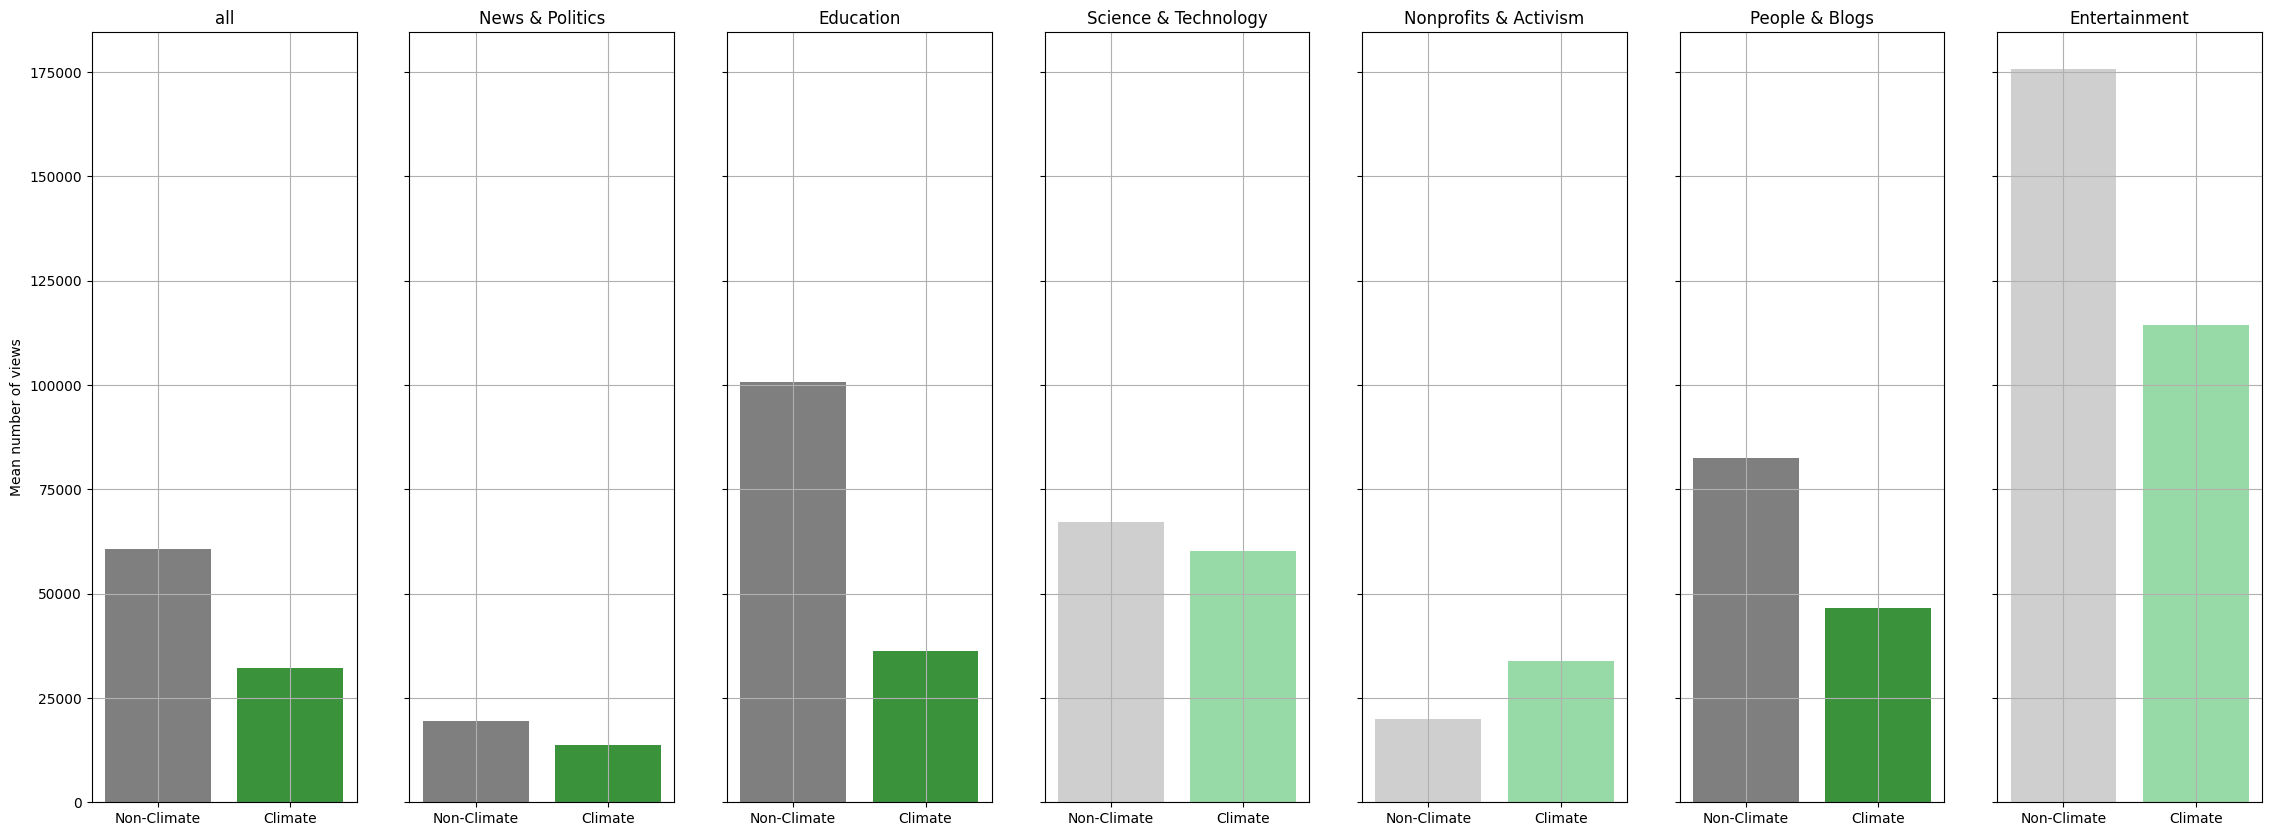

In [111]:
# Plotting
labs = ['Non-Climate', 'Climate']

# Create subplots
fig, axs = plt.subplots(1, len(relevent_cat)+ 1 , figsize=(4 * (len(relevent_cat)+1), 10), sharey=True)

statistically_relevent_colors = (sns.color_palette()[7], sns.color_palette()[2])
non_statistically_relevent_colors = (sns.color_palette('pastel')[7], sns.color_palette('pastel')[2])

# Iterate through the categories and create a bar plot for each
for idx, category in enumerate(['all'] + relevent_cat):
        # Extract data for the current category
        non_climate_views = regression_results_views[category]['intercept']
        climate_views = regression_results_views[category]['climate_intercept']
        
        if regression_results_views[category]['coeff_p-value'] < 0.05:
            colors = statistically_relevent_colors
        else:
            colors = non_statistically_relevent_colors

        # Create a bar plot for the current category
        sns.barplot(
            x=labs,
            y=[non_climate_views, climate_views],
            palette= colors,
            ax=axs[idx]
        )
        # Set the title and labels for the current plot
        axs[idx].set_title(f'{category}')
        axs[idx].grid(True)

axs[0].set_ylabel('Mean number of views')

# Adjust layout and display the plot
plt.show()

As we can see the number being a climate videos influences a lot the number of views

Now we want to study if being a climate videos influence the number of likes, dislikes and related. Here we also perform a a matching on the number of views since thsi may be confounder influencing these variables 

We use a special greedy matching given the size of the data. For each perfect categories,month match, we match a climate videos to the non climate videos that has the closest number of views and iterate that process until all climate videos that can be matched are matched.
"Can be matched" meaning:
- There exist perfect matching on categories and month
- There exist videos with less than 35% of relative difference in number of views within this perfect match

In [112]:
obs_study_climate_videos_df = obs_study_climate_videos_df.sort_values('view_count')
obs_study_climate_videos_df['view_count'] = obs_study_climate_videos_df['view_count'].astype(int)
obs_study_climate_videos_df['view_count_climate'] = obs_study_climate_videos_df['view_count']

obs_study_non_climate_videos_df = obs_study_non_climate_videos_df.sort_values('view_count')
obs_study_non_climate_videos_df['view_count'] = obs_study_non_climate_videos_df['view_count'].astype(int)
obs_study_non_climate_videos_df['view_count_non_climate'] = obs_study_non_climate_videos_df['view_count']

not_matched_climate_videos_df = obs_study_climate_videos_df #climate videos who were not matched (all of them for now)
not_matched_non_climate_videos_df = obs_study_non_climate_videos_df #non climate videos who were not matched (all of them for now)

matching_df = pd.DataFrame()

while not_matched_climate_videos_df.shape[0] > 0: #purpose is to matched as many climate videos as possible

    not_matched_climate_videos_df = not_matched_climate_videos_df.sort_values('view_count') #sorting to be able to use merge_asof
    not_matched_non_climate_videos_df = not_matched_non_climate_videos_df.sort_values('view_count')


    matching_2_df = pd.merge_asof(
                                left = not_matched_climate_videos_df,
                                right = not_matched_non_climate_videos_df, 
                                on='view_count', #nearest match on view count
                                by=['categories', 'month'], #exact match on categories and month
                                suffixes=('_climate', '_non_climate'), direction = 'nearest')
    
    matching_2_df['relative_diff'] = (matching_2_df['view_count_climate'] - matching_2_df['view_count_non_climate']).abs()/matching_2_df[['view_count_non_climate', 'view_count_climate']].max(axis=1)
                                            #view_count relative differences in the match we found
    
    #allowing only matches with samll enough view count relative_diff
    matching_2_df = matching_2_df.sort_values('relative_diff')
    matching_2_df = matching_2_df[matching_2_df['relative_diff'] < 0.1]

    #Since several_climate_videos may have been matched with a single non_climate_videos, we only keep the best match for each duplicates 
    matching_2_df_filtered = matching_2_df.drop_duplicates(subset = 'display_id_non_climate', keep ='first')

    #not matched dfs are updated: climate_videos who were droped when we droped the duplicates above.
    not_matched_climate_videos_df = not_matched_climate_videos_df[~not_matched_climate_videos_df['display_id'].isin(matching_2_df_filtered['display_id_climate'])
                                                            & not_matched_climate_videos_df['display_id'].isin(matching_2_df['display_id_climate'])]
    #non_climate_videos who were not yet used for a match
    not_matched_non_climate_videos_df = not_matched_non_climate_videos_df[~not_matched_non_climate_videos_df['display_id'].isin(matching_2_df['display_id_non_climate'])]

    #updating the matching
    matching_df = pd.concat([matching_df, matching_2_df_filtered])

climate_ids = matching_df['display_id_climate']
non_climate_ids = matching_df['display_id_non_climate']
matching_df = matching_df.drop(columns= ['view_count', 'relative_diff'])

In [113]:
#Building observational study dataframe
climate_cols = [name for name in matching_df.columns if 'non_climate' not in name]
non_climate_cols = ['categories','month'] +  [name for name in matching_df.columns if 'non_climate'  in name]

climate_matched = matching_df[climate_cols]
climate_matched = climate_matched.rename(columns = {old : new for old,new in zip(sorted(climate_matched.columns), sorted(columns))})

non_climate_matched = matching_df[non_climate_cols]
non_climate_matched = non_climate_matched.rename(columns = {old : new for old,new in zip(sorted(non_climate_matched.columns), sorted(columns))})

obs_study_df = pd.concat([climate_matched,non_climate_matched])

**We study like/dislikes comparison metrics**

Among these we introduce the sysmetric like-dislike ratio :

$$SLDR(N_{like}, N_{dislike}) =  (-1)^{\delta} \dfrac{\max{(N_{like} , N_{dislike}) + 1}}{\min{(N_{like} , N_{dislike} ) +1 } }$$

$$ \delta = 0 \text{  if  } N_{like} \geq N_{dislike}, \delta = 1 \text{  otherwise}$$

What to undestand fro this formula:
- If there are more like it is simply the like/dislike ratio (the +1 to avoid dividing by 0)
- If there are more dislike it is simply the dislike/like ratio (the +1 to avoid dividing by 0) with mimnus sign in front

In [114]:
def sldr(like_count, dislike_count):
    mask = (like_count == 0) & (dislike_count == 0)
    result = np.where(
        mask,
        1,
        np.where(
            like_count >= dislike_count,
            (like_count + 1) / (dislike_count + 1),
            - (dislike_count + 1) / (like_count + 1)
        )
    )
    return result

In [133]:
obs_study_df['like_prop'] = obs_study_df['like_count']/obs_study_df['view_count'] * 100
obs_study_df['dislike_prop'] = obs_study_df['dislike_count']/obs_study_df['view_count'] * 100
obs_study_df['engagement_rate'] = obs_study_df['like_prop'] + obs_study_df['dislike_prop']
obs_study_df['sldr'] = sldr(obs_study_df['like_count'], obs_study_df['dislike_count']) 
obs_study_df['dislike_to_like'] = np.where(
                    (obs_study_df['like_count'] == 0) & (obs_study_df['dislike_count'] == 0),
                    0.5,
                    obs_study_df['dislike_count']/(obs_study_df['like_count'] + obs_study_df['dislike_count'])) * 100

metrics_titling = {'like_prop': 'Percentage of like to views (%)',
                   'dislike_prop': 'Percentage of dislike to views (%)',
                   'engagement_rate': 'Engagement rate (%)',
                   'sldr': 'SLDR',
                   'dislike_to_like': 'Percentage of dislikes to  number of likes (%)'}

metrics =metrics_titling.keys()

In [136]:
regression_results_like = {'all' : {}}

for metric in metrics:
    model = smf.ols(formula=f"{metric} ~ is_climate", data=obs_study_df)
    result = model.fit()
    intercept, coef = result.params
    inter_p, coef_p = result.pvalues
    regression_results_like['all'][metric] = {'intercept': intercept, 'is_climate_coeff': coef, 'intercept_p-value' : inter_p, 'coeff_p-value': coef_p, 'climate_intercept': intercept + coef}

for categorie in relevent_cat:
    regression_results_like[categorie] = {}
    for metric in metrics:
        model = smf.ols(formula=f"{metric} ~ is_climate", data=obs_study_df[obs_study_df['categories'] == categorie])
        result = model.fit()
        intercept, coef = result.params
        inter_p, coef_p = result.pvalues
        regression_results_like[categorie][metric] = {'intercept': intercept, 'is_climate_coeff': coef, 'intercept_p-value' : inter_p, 'coeff_p-value': coef_p, 'climate_intercept': intercept + coef}

/Users/paul/anaconda3/envs/ADAenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/paul/anaconda3/envs/ADAenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/paul/anaconda3/envs/ADAenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

/Users/paul/anaconda3/envs/ADAenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/paul/anaconda3/envs/ADAenv/lib/python3.11/site-packages/seaborn

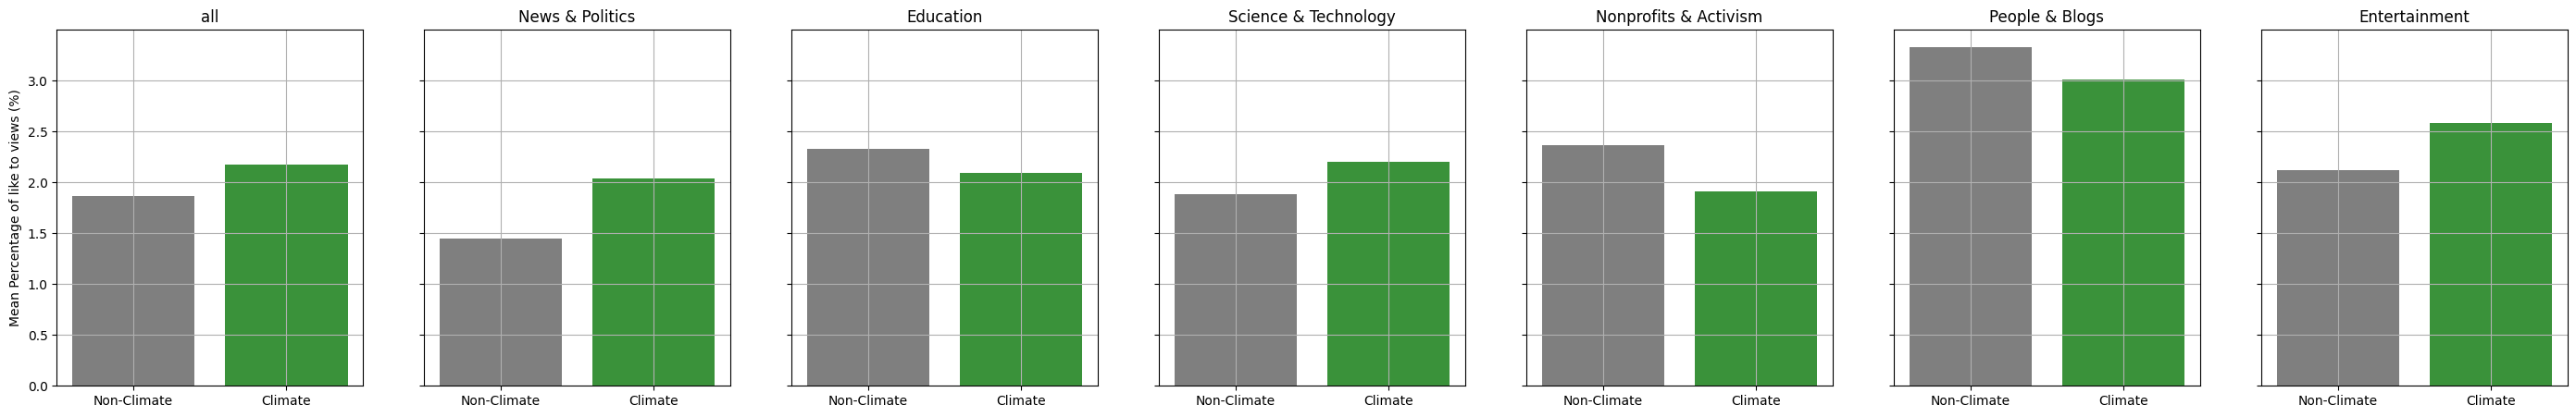

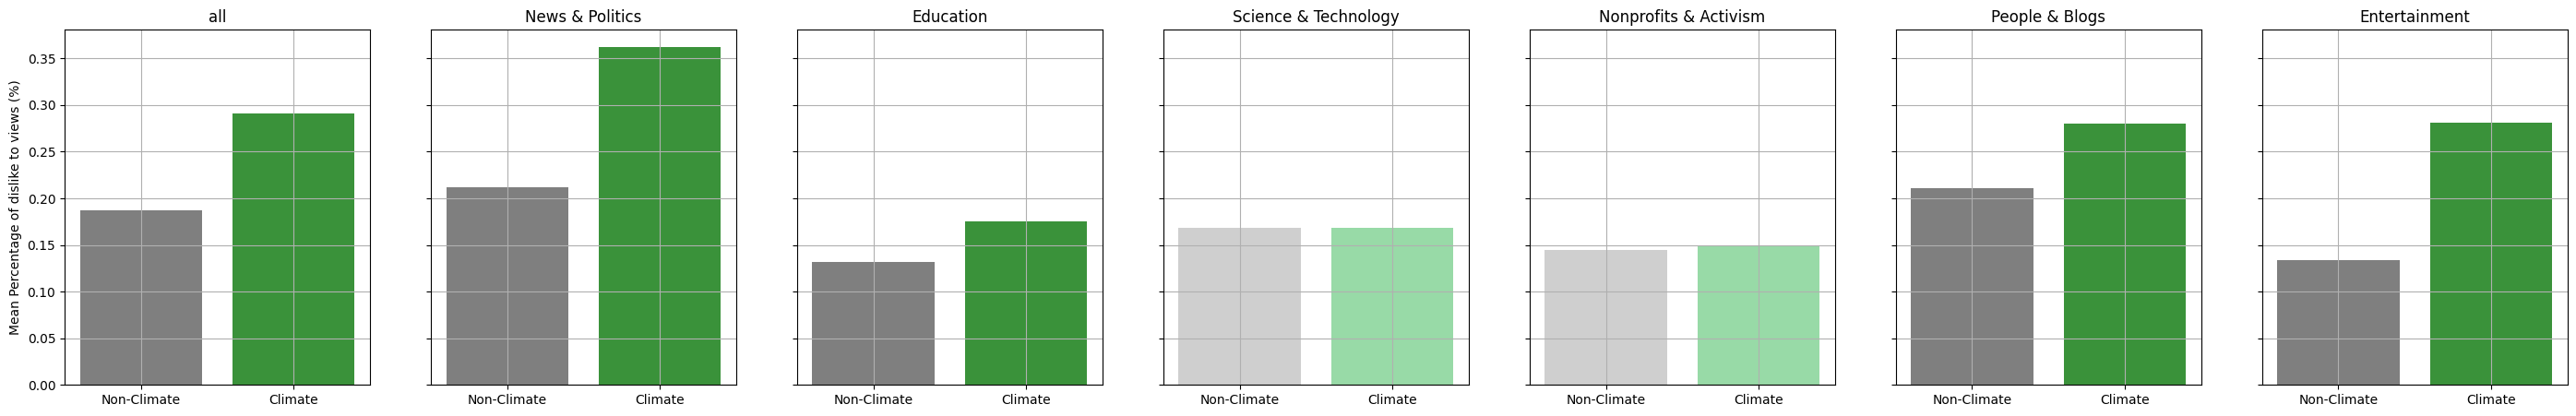

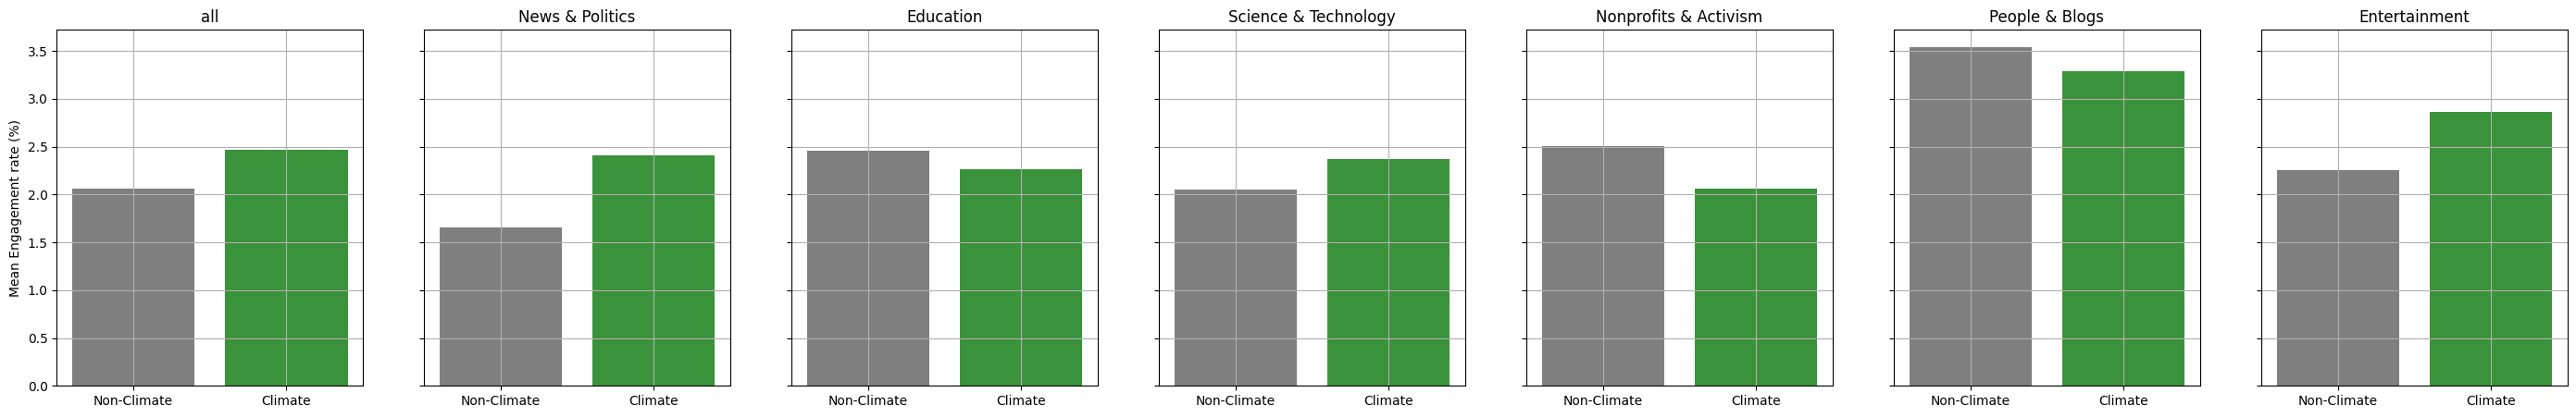

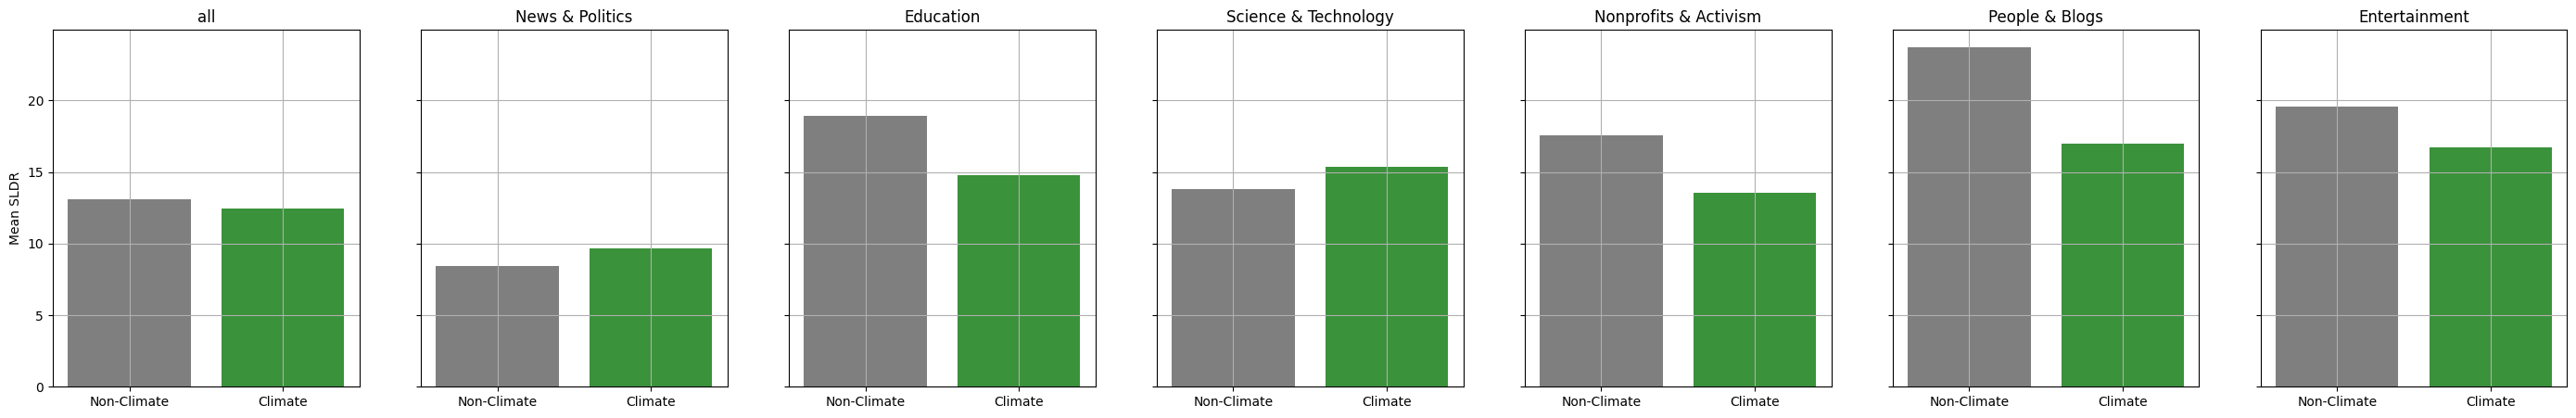

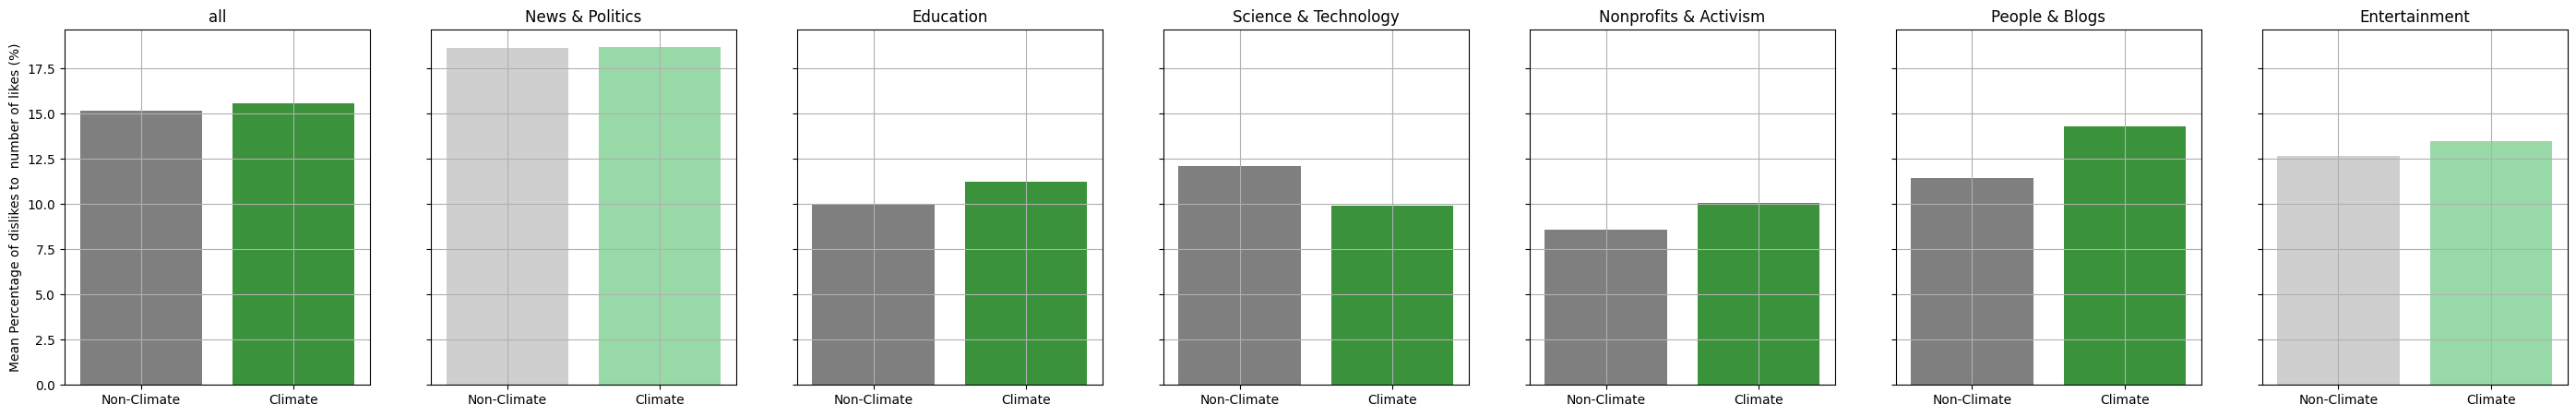

In [142]:
labs = ['Non-Climate', 'Climate']
statistically_relevant_colors = (sns.color_palette()[7], sns.color_palette()[2])
non_statistically_relevant_colors = (sns.color_palette('pastel')[7], sns.color_palette('pastel')[2])


# Create subplots for each metric
for _, metric in enumerate(metrics):
    fig, axs = plt.subplots(1, len(regression_results_like), figsize=(5*(len(regression_results_like)),5), sharey = True)
    axs[0].set_ylabel(f'Mean {metrics_titling[metric]}')

    for idx, category in enumerate(['all'] + relevent_cat):
        # Extract data for the current category
        non_climate_metric = regression_results_like[category][metric]['intercept']
        climate_metric = regression_results_like[category][metric]['climate_intercept']
        
        if regression_results_like[category][metric]['coeff_p-value'] < 0.05:
            colors = statistically_relevent_colors
        else:
            colors = non_statistically_relevent_colors

        # Create a bar plot for the current category
        sns.barplot(
            x=labs,
            y=[non_climate_metric, climate_metric],
            palette= colors,
            ax=axs[idx]
        )
        # Set the title and labels for the current plot
        axs[idx].set_title(f'{category}')
        axs[idx].grid(True)



# Adjust layout and display the plot
plt.show()

    